In [108]:
import numpy as np
import pandas as pd
import iris
import glob
import sys
import os
import cartopy.crs as ccrs
import itertools
from scipy import spatial
import numpy.ma as ma
import tilemapbase

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from warnings import simplefilter
warnings.filterwarnings("ignore", category =UserWarning,)

In [59]:
def find_position_obs (concat_cube, lat, lon, station_name):
    lat_length = concat_cube.shape[1]
    lon_length = concat_cube.shape[2]
    # Convert WGS84 coordinate to BNG
    lon_bng,lat_bng = transform(Proj(init = 'epsg:4326') , Proj(init = 'epsg:27700'),
                                lon, lat)
    # Create as a list
    sample_point = [('grid_latitude', lat_bng), ('grid_longitude', lon_bng)]
             
    # Create a list of all the tuple pairs of latitude and longitudes
    locations = list(itertools.product(concat_cube.coord('projection_y_coordinate').points,
                                       concat_cube.coord('projection_x_coordinate').points))
    
    # Find the index of the nearest neighbour of the sample point in the list of locations present in concat_cube
    tree = spatial.KDTree(locations)
    closest_point_idx = tree.query([(sample_point[0][1], sample_point[1][1])], k =1)[1][0]
    
    # Create a list of all the tuple positions
    indexs_lst = []
    for i in range(0,lat_length):
        for j in range(0,lon_length):
            # Print the position
            #print(i,j)
            indexs_lst.append((i,j))
         
    # Extract the lat and long values of this point using the index
    filename = "Outputs/TimeSeries/CEH-GEAR/1km/leeds-at-centre/{}_{}.npy".format(indexs_lst[closest_point_idx][0],indexs_lst[closest_point_idx][1])
    data_slice = np.load(filename)
     
    # Get the times
    times = np.load('Outputs/TimeSeries/CEH-GEAR/1km/leeds-at-centre/timestamps.npy', allow_pickle = True)
         
    # Create dataframe
    df = pd.DataFrame({'Times': times, 'Precipitation (mm/hr)':data_slice})
     
    ######## Check plotting 
    # Get cube containing one hour worth of data
    hour_uk_cube = concat_cube[0,:,:]

    # Set all the values to 0
    test_data = np.full((hour_uk_cube.shape),0,dtype = int)
    # Set the values at the index position fond above to 1
    test_data[indexs_lst[closest_point_idx][0],indexs_lst[closest_point_idx][1]] = 1
    # Mask out all values that aren't 1
    test_data = ma.masked_where(test_data<1,test_data)
    
    # Set the dummy data back on the cube
    hour_uk_cube.data = test_data
    
    # Find cornerpoint coordinates (for use in plotting)
    lats_cornerpoints = find_cornerpoint_coordinates_obs(hour_uk_cube)[0]
    lons_cornerpoints = find_cornerpoint_coordinates_obs(hour_uk_cube)[1]
    
    # Trim the data timeslice to be the same dimensions as the corner coordinates
    hour_uk_cube = hour_uk_cube[1:,1:]
    test_data = hour_uk_cube.data

    # Create location in web mercator for plotting
    print('Creating plot')
    lon_wm,lat_wm = transform(Proj(init = 'epsg:4326') , Proj(init = 'epsg:3857') , lon, lat)
    
    # Create a colormap
    cmap = matplotlib.colors.ListedColormap(['red'])
    
    fig, ax = plt.subplots(figsize=(30,30))
    extent = tilemapbase.extent_from_frame(leeds_at_centre_gdf)
    plot = plotter = tilemapbase.Plotter(extent, tilemapbase.tiles.build_OSM(), width=500)
    plot =plotter.plot(ax)
    # # Add edgecolor = 'grey' for lines
    plot =ax.pcolormesh(lons_cornerpoints, lats_cornerpoints, test_data,
          linewidths=0.4, alpha = 1, cmap = cmap, edgecolors = 'grey')
    plot = ax.xaxis.set_major_formatter(plt.NullFormatter())
    plot = ax.yaxis.set_major_formatter(plt.NullFormatter())
    plot =leeds_gdf.plot(ax=ax, categorical=True, alpha=1, edgecolor='black', color='none', linewidth=2)
    plot =leeds_at_centre_gdf.plot(ax=ax, categorical=True, alpha=1, edgecolor='black', color='none', linewidth=2)
    plt.plot(lon_wm, lat_wm,  'o', color='black', markersize = 10)     
    #plt.savefig('Scripts/UKCP18/RainGaugeAnalysis/Figs/CheckingLocations/CEH-GEAR/{}.png'.format(station_name),
    #            bbox_inches = 'tight')
    plt.show()
 
    return (df, closest_point_idx)    
# Set up path to root directory
root_fp = "/nfs/a319/gy17m2a/PhD/"
os.chdir(root_fp)

sys.path.insert(0, root_fp + 'Scripts/GlobalFunctions')
from Spatial_plotting_functions import *
from Spatial_geometry_functions import *

In [17]:
# Replace 'your_file_path.txt' with the path to your text file
file_path = '/nfs/a319/gy17m2a/PhD/datadir/RainGauge/interarrival_thresholds_CDD_noMissing.txt'

# Read the CSV data into a DataFrame
tbo_vals = pd.read_csv(file_path)

In [19]:
tbo_vals = tbo_vals.sort_values(by='Critical_interarrival_time')

1294

## Read in rain gauge data and see if they match (no reason to do this?)

## Find UKCP18 grid cell which each gauge is within

### Get UKCP18 data

In [111]:
em = '01'
in_jja=iris.Constraint(time=lambda cell: 6 <= cell.point.month <= 8)

yrs_range = "1980_2001"
yrs= range(1981,2002)

resolution = '2.2km' #2.2km, 12km, 2.2km_regridded_12km
regridding_style = 'AreaWeighted'

gb_gdf = create_gb_outline({'init' :'epsg:3857'})
# This is a square area surrounding Leeds
leeds_at_centre_gdf = create_leeds_at_centre_outline({'init' :'epsg:3857'})

In [60]:
yr = 1985
general_filename = f'/nfs/a319/gy17m2a/PhD/datadir/UKCP18_hourly/{resolution}/{em}/{yrs_range}/pr_rcp85_land-cpm_uk_2.2km_{em}_1hr_{yr}*'

filenames = []
for filename in glob.glob(general_filename):
    filenames.append(filename)
print(f"loading {len(filenames)} files")

# ### Load in the data
monthly_cubes_list = iris.load(filenames, in_jja)
print(len(monthly_cubes_list))

for cube in monthly_cubes_list:
     for attr in ['creation_date', 'tracking_id', 'history', 'Conventions']:
            if attr in cube.attributes:
                del cube.attributes[attr]

# ### Concatenate cubes into one
model_cube = monthly_cubes_list.concatenate_cube()      

### Remove ensemble member dimension
if len(model_cube.shape)>3:
    model_cube = model_cube[0,:,:,:]  

/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/ukcp18/lib/python3.7/site-packages/pyproj/crs/crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/ukcp18/lib/python3.7/site-packages/pyproj/crs/crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


loading 3 files
3


In [63]:
model_cube = trim_to_bbox_of_region_regriddedobs(model_cube, gb_gdf)

In [64]:
# ### Get the mask
print("getting mask")
if resolution =='2.2km':
    gb_mask = np.load("/nfs/a319/gy17m2a/PhD/datadir/UKCP18_2.2km_GB_Mask.npy")
elif resolution =='2.2km_regridded_12km':
    gb_mask = np.load("/nfs/a319/gy17m2a/PhD/datadir/UKCP18_12km_wgs84_GB_Mask.npy")
elif resolution =='2.2km_bng_regridded_12km':
    gb_mask = np.load("/nfs/a319/gy17m2a/PhD/datadir/UKCP18_12km_bng_GB_Mask.npy")
elif resolution =='2.2km_bng_regridded_12km_maskingfirst':
    gb_mask = np.load("/nfs/a319/gy17m2a/PhD/datadir/UKCP18_12km_bng_GB_Mask.npy")
else:
    gb_mask = np.load("/nfs/a319/gy17m2a/PhD/datadir/UKCP18_12km_GB_Mask.npy")
masked_cube_data = model_cube * gb_mask[np.newaxis, :, :]

# APPLY THE MASK
reshaped_mask = np.tile(gb_mask, (model_cube.shape[0], 1, 1))
reshaped_mask = reshaped_mask.astype(int)
reversed_array = ~reshaped_mask.astype(bool)

# Mask the cube
masked_cube = iris.util.mask_cube(model_cube, reversed_array)

getting mask


In [66]:
masked_cube_onets =masked_cube[0,:,:]
masked_cube_onets

<iris 'Cube' of lwe_precipitation_rate / (mm/hour) (grid_latitude: 519; grid_longitude: 423)>

In [48]:
# ddir = f"/nfs/a319/gy17m2a/PhD/ProcessedData/TimeSeries/UKCP18_hourly/{resolution}/{yrs_range}/{em}/"
# test = iris.load(ddir + f'{yr}_maskedcube.nc')   

### Get one rain gauge as an example

In [30]:
gauge1 = tbo_vals.iloc[1:2]
gauge1['Lon']

Station_id Station_name      Lon       Lat  Critical_interarrival_time
1220  SEPA234305   sgodachail -4.54636  57.89409                        2.75

In [109]:
# # Get the data values at this location
# # think the obs cube is only for finding position - hence why its one timeslice
# cehgear_df, closest_point_idx_grid = find_position(masked_cube_onets, '01', gauge1['Lat'], gauge1['Lon'], gauge1['Station_name'])
# closest_point_idx_grids.append(closest_point_idx_grid)

# # Create a formatted date column
# cehgear_df['Datetime'] = pd.to_datetime(cehgear_df['Times'], dayfirst = True)

# # remove na values
# print('NA values in CEH-GEAR: ' + str(cehgear_df['Precipitation (mm/hr)'].isna().sum()))
# cehgear_df.dropna(inplace = True)


In [136]:
def find_position (concat_cube, em, lon, lat, station_name):
    
     # Define a sample point in the correct projection
        sample_point = define_loc_of_interest(concat_cube, lon, lat)  
        print (sample_point)
        lat_length = concat_cube.shape[0]
        lon_length = concat_cube.shape[1]    

        # Create a list of all the tuple pairs of latitude and longitudes
        locations = list(itertools.product(concat_cube.coord('grid_latitude').points, concat_cube.coord('grid_longitude').points))

        # Correct them so that 360 merges back into one
        corrected_locations = []
        for location in locations:
            if location[0] >360:
                    new_lat = location[0] -360
            else: 
                 new_lat = location[0]
            if location[1] >360:
                 new_long = location[1] -360     
            else:
                 new_long = location[1]
            new_location = new_lat, new_long 
            corrected_locations.append(new_location)

         # Create a list of all the tuple positions
        indexs_lst = []
        for i in range(0,lat_length):
            for j in range(0,lon_length):
                # Print the position
                #print(i,j)
                indexs_lst.append((i,j))
          
        # Find the index of the nearest neighbour of the sample point in the list of locations present in concat_cube
        tree = spatial.KDTree(corrected_locations)
        closest_point_idx = tree.query([(sample_point[0][1], sample_point[1][1])])[1][0]
             
        return (closest_point_idx, indexs_lst)    

In [137]:
closest_point_idx, indexs_lst = find_position(masked_cube_onets, '01', gauge1['Lat'], gauge1['Lon'], gauge1['Station_name'])

[('grid_latitude', 5.409565929587365), ('grid_longitude', -1.0923111524764253)]


In [115]:
hour_uk_cube = masked_cube_onets

# Recreate data so that only the cell containing the lat, long location 
# has a data value
# Create data of the same shape as the cube and set all the values to 0
test_data = np.full((hour_uk_cube.shape),0,dtype = int)
#    
test_data[indexs_lst[closest_point_idx][0],indexs_lst[closest_point_idx][1]] = 1
# Mask out all values that aren't 1
test_data = ma.masked_where(test_data<1,test_data)

# Set the dummy data back on the cube
hour_uk_cube.data = test_data

# Create cube with all values masked out except from cell at closest_point_idx

# Find cornerpoint coordinates (for use in plotting)
lats_cornerpoints = find_cornerpoint_coordinates(hour_uk_cube)[0]
lons_cornerpoints = find_cornerpoint_coordinates(hour_uk_cube)[1]

# Trim the data timeslice to be the same dimensions as the corner coordinates
hour_uk_cube = hour_uk_cube[1:,1:]
test_data = hour_uk_cube.data

In [121]:
import matplotlib.pyplot as plt
import tilemapbase
from pyproj import Transformer

# Center point in WGS 84
lat, lon = 57.89409, -4.54636  # Replace with your specific point

# Initialize Transformer to convert from WGS 84 to Web Mercator
transformer = Transformer.from_crs("epsg:4326", "epsg:3857", always_xy=True)

# Convert center point to Web Mercator
lon_wm, lat_wm = transformer.transform(lon, lat)

# Define the extent of the 10 km x 10 km box around the converted center point in Web Mercator
# 1 degree latitude is approximately 111 km on the surface of the Earth
# Web Mercator is a projected coordinate system, so we work directly in meters
half_side_m = 5000  # 5 km for half the side of the box, making the full box 10 km x 10 km

# Calculate the extent in Web Mercator coordinates
extent = tilemapbase.Extent.from_lonlat(coords[0] - degree_range, coords[0] + degree_range, coords[1] - degree_range, coords[1] + degree_range)

# Plotting
fig, ax = plt.subplots(figsize=(30, 30))
plotter = tilemapbase.Plotter(extent, tilemapbase.tiles.build_OSM(), width=500)
plotter.plot(ax)
# Assuming lons_cornerpoints, lats_cornerpoints, and test_data are defined elsewhere in your code
ax.pcolormesh(lons_cornerpoints, lats_cornerpoints, test_data,
              linewidths=0.4, alpha=1, cmap=cmap, edgecolors='grey')
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.yaxis.set_major_formatter(plt.NullFormatter())
# Assuming leeds_at_centre_gdf is defined and relevant to the plot
# leeds_at_centre_gdf.plot(ax=ax, categorical=True, alpha=1, edgecolor='black', color='none', linewidth=2)
plt.plot(lon_wm, lat_wm, 'o', color='black', markersize=10)

plt.show()


TypeError: __init__() got an unexpected keyword argument 'left'

In [120]:
import matplotlib.pyplot as plt
import tilemapbase
from pyproj import Proj, transform

# Center point in WGS 84
lat, lon =  57.13410498826269, -3.896050849640473

# Convert center point to Web Mercator (or your map's coordinate system)
proj_wgs84 = Proj('epsg:4326')  # WGS 84
proj_web_mercator = Proj('epsg:3857')  # Web Mercator
lon_wm, lat_wm = transform(proj_wgs84, proj_web_mercator, lon, lat)

# Define the extent of the 10 km x 10 km box in Web Mercator
# Note: This is an approximation, as the actual size in meters will vary with latitude
half_side_m = 5000  # Half side of the box in meters (5 km for a 10 km x 10 km box)
extent = tilemapbase.Extent.from_lonlat(lon_wm - half_side_m, lon_wm + half_side_m,
                                        lat_wm - half_side_m, lat_wm + half_side_m)
extent = extent.to_aspect(1.0)  # Ensure the aspect ratio is 1:1

# Plot
fig, ax = plt.subplots(figsize=(30, 30))
plotter = tilemapbase.Plotter(extent, tilemapbase.tiles.build_OSM(), width=500)
plotter.plot(ax)
# ax.pcolormesh(lons_cornerpoints, lats_cornerpoints, test_data,
#               linewidths=0.4, alpha=1, cmap=cmap, edgecolors='grey')
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.yaxis.set_major_formatter(plt.NullFormatter())
leeds_at_centre_gdf.plot(ax=ax, categorical=True, alpha=1, edgecolor='black', color='none', linewidth=2)
plt.plot(lon_wm, lat_wm, 'o', color='black', markersize=10)

plt.show()


/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/ukcp18/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  # This is added back by InteractiveShellApp.init_path()


ValueError: math domain error

/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/ukcp18/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  


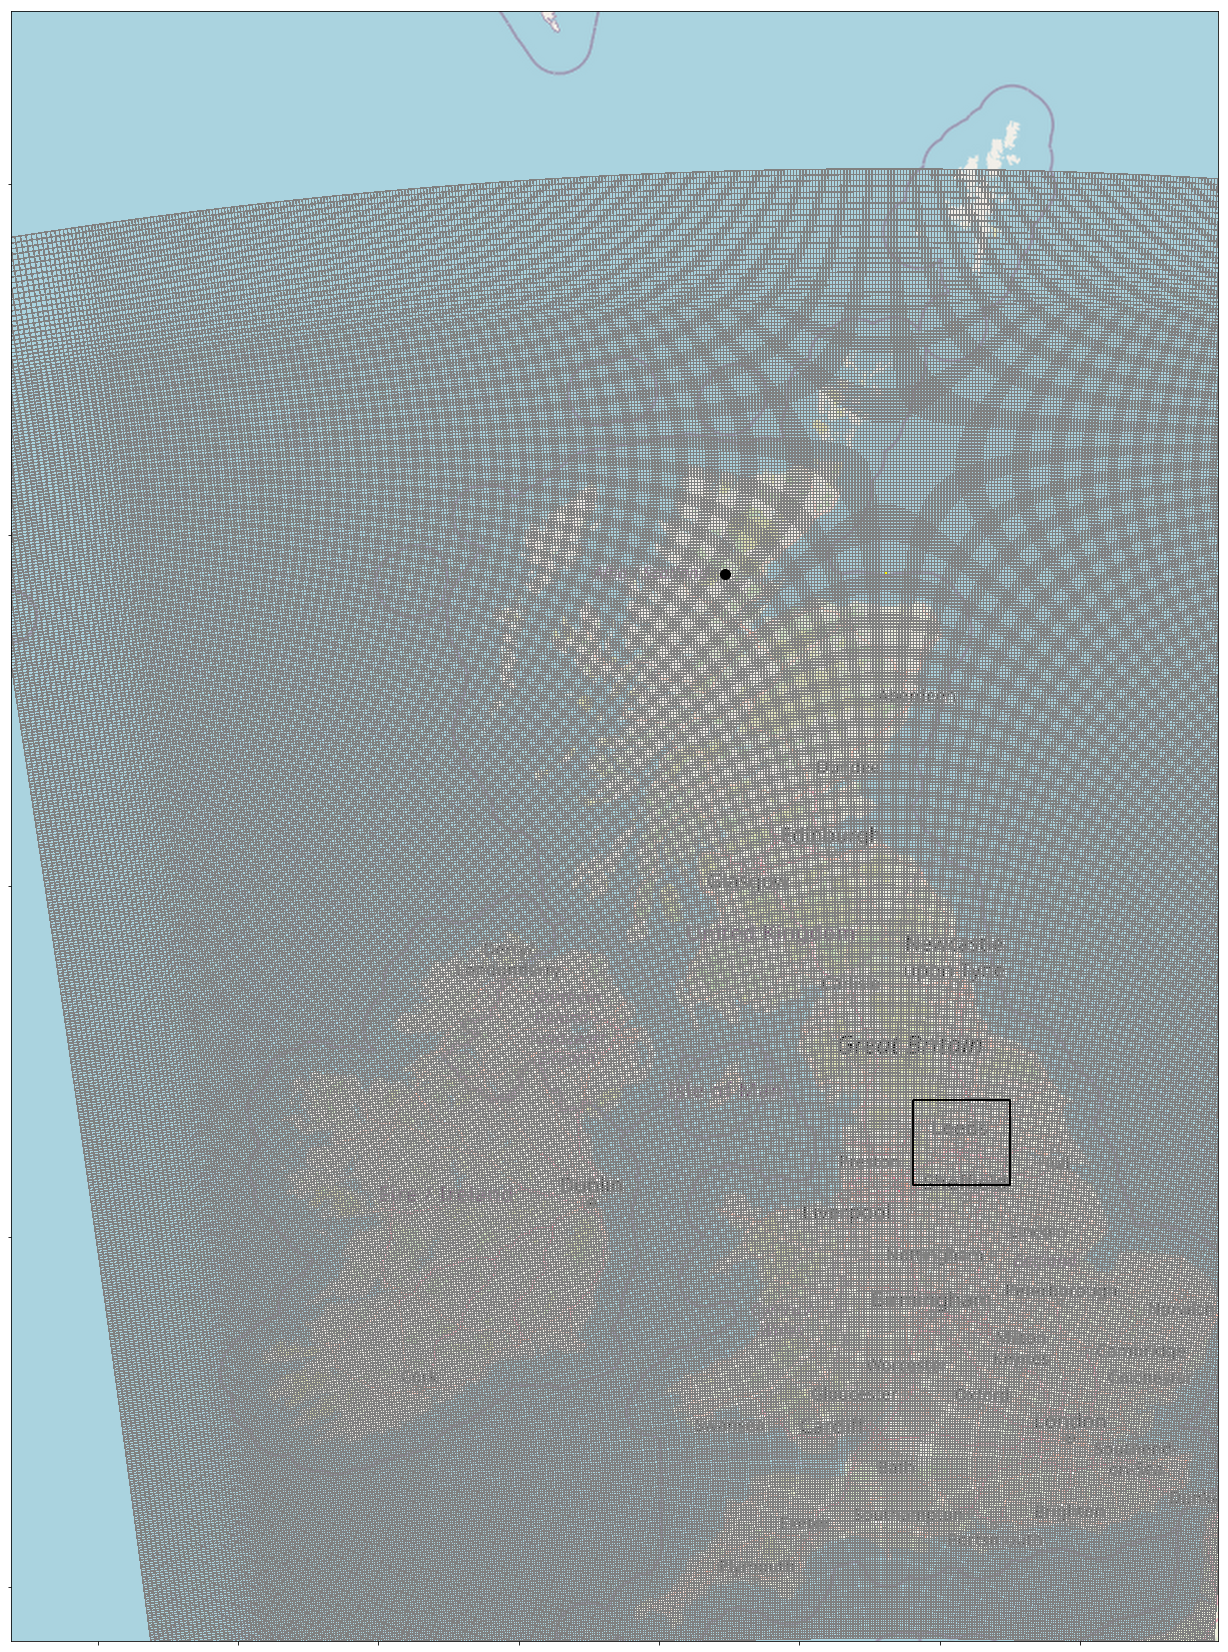

In [117]:
#lon, lat = sample_point[1][1], sample_point[0][1]
lon_wm,lat_wm = transform(Proj(init = 'epsg:4326') , Proj(init = 'epsg:3857') , lon, lat)

# Create a colormap
cmap = matplotlib.colors.ListedColormap(['yellow'])

fig, ax = plt.subplots(figsize=(30,30))
extent = tilemapbase.extent_from_frame(gb_gdf)
plot = plotter = tilemapbase.Plotter(extent, tilemapbase.tiles.build_OSM(), width=500)
plot =plotter.plot(ax)
# # Add edgecolor = 'grey' for lines
plot =ax.pcolormesh(lons_cornerpoints, lats_cornerpoints, test_data,
      linewidths=0.4, alpha = 1, cmap = cmap, edgecolors = 'grey')
plot = ax.xaxis.set_major_formatter(plt.NullFormatter())
plot = ax.yaxis.set_major_formatter(plt.NullFormatter())
# plot =leeds_gdf.plot(ax=ax, categorical=True, alpha=1, edgecolor='black', color='none', linewidth=2)
plot =leeds_at_centre_gdf.plot(ax=ax, categorical=True, alpha=1, edgecolor='black', color='none', linewidth=2)
plt.plot(lon_wm, lat_wm,  'o', color='black', markersize = 10)     
#plt.savefig('Scripts/UKCP18/RainGaugeAnalysis/Figs/CheckingLocations/UKCP18/{}.png'.format(station_name),
#           bbox_inches = 'tight')
plt.show()

In [85]:
def define_loc_of_interest(cube, lat, lon):
    #############################################
    # Define a sample point at which we are interested in extracting the precipitation timeseries.
    # Assign this the same projection as the projection data
    #############################################
    # Create a cartopy CRS representing the coordinate sytem of the data in the cube.
    rot_pole = cube[0].coord('grid_latitude').coord_system.as_cartopy_crs()
    
    # Define a sample point of interest, in standard lat/long.
    # Use the rot_pole CRS to transform the sample point, with the stated original CRS into the same system
    original_crs = ccrs.Geodetic() # Instantiate an instance of Geodetic class i.e. that used in WGS
    target_xy = rot_pole.transform_point(lon, lat, original_crs) # https://scitools.org.uk/cartopy/docs/v0.14/crs/index.html
       
    # Store the sample point of interest as a tuples (with their coordinate name) in a list
    sample_points = [('grid_latitude', target_xy[1]), ('grid_longitude', target_xy[0])]
    return(sample_points)

sample_point = define_loc_of_interest(masked_cube_onets, gauge1['Lat'], gauge1['Lon']) 
sample_point

[('grid_latitude', 5.409565929587365), ('grid_longitude', -1.0923111524764253)]

In [92]:
concat_cube = masked_cube_onets
lat_length = concat_cube.shape[0]
lon_length = concat_cube.shape[1]    

# Create a list of all the tuple pairs of latitude and longitudes
locations = list(itertools.product(concat_cube.coord('grid_latitude').points, concat_cube.coord('grid_longitude').points))


[(-2.61995005607605, 353.9359436035156),
 (-2.61995005607605, 353.9719543457031),
 (-2.61995005607605, 354.0079650878906),
 (-2.61995005607605, 354.0439453125),
 (-2.61995005607605, 354.0799560546875),
 (-2.61995005607605, 354.1159362792969),
 (-2.61995005607605, 354.1519470214844),
 (-2.61995005607605, 354.1879577636719),
 (-2.61995005607605, 354.22393798828125),
 (-2.61995005607605, 354.25994873046875),
 (-2.61995005607605, 354.29595947265625),
 (-2.61995005607605, 354.3319396972656),
 (-2.61995005607605, 354.3679504394531),
 (-2.61995005607605, 354.4039611816406),
 (-2.61995005607605, 354.43994140625),
 (-2.61995005607605, 354.4759521484375),
 (-2.61995005607605, 354.5107421875),
 (-2.61995005607605, 354.5443115234375),
 (-2.61995005607605, 354.5767822265625),
 (-2.61995005607605, 354.6081237792969),
 (-2.61995005607605, 354.6383972167969),
 (-2.61995005607605, 354.66766357421875),
 (-2.61995005607605, 354.6959228515625),
 (-2.61995005607605, 354.7232360839844),
 (-2.61995005607605,

In [101]:
def find_position (concat_cube, em, lon, lat, station_name):
    
     # Define a sample point in the correct projection
        sample_point = define_loc_of_interest(concat_cube, lon, lat)  
    
        lat_length = concat_cube.shape[0]
        lon_length = concat_cube.shape[1]    

        # Create a list of all the tuple pairs of latitude and longitudes
        locations = list(itertools.product(concat_cube.coord('grid_latitude').points, concat_cube.coord('grid_longitude').points))

        # Correct them so that 360 merges back into one
        corrected_locations = []
        for location in locations:
            if location[0] >360:
                    new_lat = location[0] -360
            else: 
                 new_lat = location[0]
            if location[1] >360:
                 new_long = location[1] -360     
            else:
                 new_long = location[1]
            new_location = new_lat, new_long 
            corrected_locations.append(new_location)

         # Create a list of all the tuple positions
        indexs_lst = []
        for i in range(0,lat_length):
            for j in range(0,lon_length):
                # Print the position
                #print(i,j)
                indexs_lst.append((i,j))
          
        # Find the index of the nearest neighbour of the sample point in the list of locations present in concat_cube
        tree = spatial.KDTree(corrected_locations)
        closest_point_idx = tree.query([(sample_point[0][1], sample_point[1][1])])[1][0]
             
        return (closest_point_idx, indexs_lst)    
    
# def find_position (concat_cube, em, lon, lat, station_name):
     
#         # Extract the lat and long values of this point using the index
#         filename = 'Outputs/TimeSeries/UKCP18/Baseline/leeds-at-centre/{}/{}_{}.npy'.format(em, indexs_lst[closest_point_idx][0],indexs_lst[closest_point_idx][1])
#         data_slice = np.load(filename)

#         # Get the times
#         times = np.load('Outputs/TimeSeries/UKCP18/Baseline/leeds-at-centre/timestamps.npy')

#         # Create dataframe
#         df = pd.DataFrame({'Times': times, 'Precipitation (mm/hr)':data_slice})

#         ######## Check plotting 
#         hour_uk_cube = concat_cube[0,:,:]
        
#         # Recreate data so that only the cell containing the lat, long location 
#         # has a data value
#         # Create data of the same shape as the cube and set all the values to 0
#         test_data = np.full((hour_uk_cube.shape),0,dtype = int)
#         #    
#         test_data[indexs_lst[closest_point_idx][0],indexs_lst[closest_point_idx][1]] = 1
#         # Mask out all values that aren't 1
#         test_data = ma.masked_where(test_data<1,test_data)

#         # Set the dummy data back on the cube
#         hour_uk_cube.data = test_data

#         # Create cube with all values masked out except from cell at closest_point_idx
        
#         # Find cornerpoint coordinates (for use in plotting)
#         lats_cornerpoints = find_cornerpoint_coordinates(hour_uk_cube)[0]
#         lons_cornerpoints = find_cornerpoint_coordinates(hour_uk_cube)[1]
        
#         # Trim the data timeslice to be the same dimensions as the corner coordinates
#         hour_uk_cube = hour_uk_cube[1:,1:]
#         test_data = hour_uk_cube.data

#         # Create location in web mercator for plotting
#         print('Creating plot')
#         if em == '01':
#             #lon, lat = sample_point[1][1], sample_point[0][1]
#             lon_wm,lat_wm = transform(Proj(init = 'epsg:4326') , Proj(init = 'epsg:3857') , lon, lat)
           
#             # Create a colormap
#             cmap = matplotlib.colors.ListedColormap(['yellow'])
           
#             fig, ax = plt.subplots(figsize=(30,30))
#             extent = tilemapbase.extent_from_frame(leeds_at_centre_gdf)
#             plot = plotter = tilemapbase.Plotter(extent, tilemapbase.tiles.build_OSM(), width=500)
#             plot =plotter.plot(ax)
#             # # Add edgecolor = 'grey' for lines
#             plot =ax.pcolormesh(lons_cornerpoints, lats_cornerpoints, test_data,
#                   linewidths=0.4, alpha = 1, cmap = cmap, edgecolors = 'grey')
#             plot = ax.xaxis.set_major_formatter(plt.NullFormatter())
#             plot = ax.yaxis.set_major_formatter(plt.NullFormatter())
#             plot =leeds_gdf.plot(ax=ax, categorical=True, alpha=1, edgecolor='black', color='none', linewidth=2)
#             plot =leeds_at_centre_gdf.plot(ax=ax, categorical=True, alpha=1, edgecolor='black', color='none', linewidth=2)
#             plt.plot(lon_wm, lat_wm,  'o', color='black', markersize = 10)     
#             plt.savefig('Scripts/UKCP18/RainGaugeAnalysis/Figs/CheckingLocations/UKCP18/{}.png'.format(station_name),
#                         bbox_inches = 'tight')
#             plt.show()
        
#         return (df,closest_point_idx)    

In [72]:
def define_loc_of_interest(cube, lon, lat):
    #############################################
    # Define a sample point at which we are interested in extracting the precipitation timeseries.
    # Assign this the same projection as the projection data
    #############################################
    # Create a cartopy CRS representing the coordinate sytem of the data in the cube.
    rot_pole = cube[0].coord('grid_latitude').coord_system.as_cartopy_crs()
    
    # Define a sample point of interest, in standard lat/long.
    # Use the rot_pole CRS to transform the sample point, with the stated original CRS into the same system
    original_crs = ccrs.Geodetic() # Instantiate an instance of Geodetic class i.e. that used in WGS
    target_xy = rot_pole.transform_point(lon, lat, original_crs) # https://scitools.org.uk/cartopy/docs/v0.14/crs/index.html
       
    # Store the sample point of interest as a tuples (with their coordinate name) in a list
    sample_points = [('grid_latitude', target_xy[1]), ('grid_longitude', target_xy[0])]
    return(sample_points)

### Start: chatGPT

In [86]:
from pyproj import Proj, transform

# Example rotated pole parameters - replace these with your actual parameters
rotated_pole_lon = -177.5  # longitude of rotated pole
rotated_pole_lat = 37.5  # latitude of rotated pole

# Define the WGS 84 projection
proj_wgs84 = Proj(proj='latlong', datum='WGS84')

# Define the rotated pole projection
proj_rotated = Proj(proj='ob_tran', o_proj='latlon', o_lon_p=rotated_pole_lon, o_lat_p=rotated_pole_lat, lon_0=180)

# Coordinates to transform (WGS 84)
lon, lat = -4.54636, 57.89409

# Transform coordinates from WGS 84 to rotated pole CRS
x_rotated, y_rotated = transform(proj_wgs84, proj_rotated, lon, lat)

print(f"Rotated pole coordinates: {x_rotated}, {y_rotated}")

Rotated pole coordinates: -170.6266186082225, 69.38887603783915


/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/ukcp18/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1


In [87]:
x_rotated, y_rotated

(-170.6266186082225, 69.38887603783915)

In [79]:
grid_lat

array([-2.61995006e+00, -2.59995008e+00, -2.57995009e+00, -2.55995011e+00,
       -2.53994989e+00, -2.51994991e+00, -2.49994993e+00, -2.47994995e+00,
       -2.45994997e+00, -2.43994999e+00, -2.41995001e+00, -2.39995003e+00,
       -2.37995005e+00, -2.35995007e+00, -2.33995008e+00, -2.31995010e+00,
       -2.29994988e+00, -2.27994990e+00, -2.25994992e+00, -2.23994994e+00,
       -2.21994996e+00, -2.19994998e+00, -2.17995000e+00, -2.15995002e+00,
       -2.13995004e+00, -2.11995006e+00, -2.09995008e+00, -2.07995009e+00,
       -2.05995011e+00, -2.03994989e+00, -2.01994991e+00, -1.99995005e+00,
       -1.97994995e+00, -1.95994997e+00, -1.93994999e+00, -1.91995001e+00,
       -1.89995003e+00, -1.87995005e+00, -1.85994995e+00, -1.83994997e+00,
       -1.81994998e+00, -1.79995000e+00, -1.77995002e+00, -1.75995004e+00,
       -1.73994994e+00, -1.71994996e+00, -1.69994998e+00, -1.67995000e+00,
       -1.65995002e+00, -1.63995004e+00, -1.61995006e+00, -1.59994996e+00,
       -1.57994998e+00, -

In [80]:
import iris
import numpy as np
cube = masked_cube_onets
# Load your Iris cube (assuming it's already loaded as `cube`)

import numpy as np

# Assuming grid_lat and grid_lon are 1D arrays from your Iris cube
# You need to create a 2D meshgrid that represents all combinations of these coordinates

grid_lat_2d, grid_lon_2d = np.meshgrid(cube.coord('grid_latitude').points, cube.coord('grid_longitude').points, indexing='ij')

# Ensure the calculation is performed correctly by broadcasting
# Convert the rotated coordinates to match your grid's system if not already done
x_rotated, y_rotated = -4.54636, 57.89409  # Example rotated coordinates, replace with your actual converted values

# Calculate the distance to all points in the grid
distances = np.sqrt((grid_lat_2d - y_rotated)**2 + (grid_lon_2d - x_rotated)**2)

# Find the index of the minimum distance
min_dist_idx = np.unravel_index(np.argmin(distances), distances.shape)

print(f"Nearest grid cell index: {min_dist_idx}")


Nearest grid cell index: (518, 0)


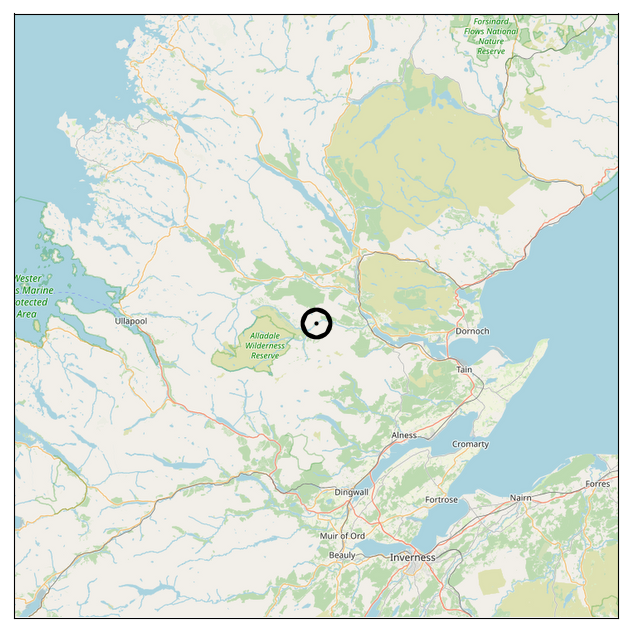

In [129]:
# import matplotlib.pyplot as plt
# tilemapbase.init(create=True)
# t = tilemapbase.tiles.build_OSM()
# # My current office at the University of Leeds
# my_office = (-1.554934, 53.804198)
# my_office = (-4.54636, 57.89409)

degree_range = 1
extent = tilemapbase.Extent.from_lonlat(my_office[0] - degree_range, my_office[0] + degree_range,
                  my_office[1] - degree_range, my_office[1] + degree_range)
extent = extent.to_aspect(1.0)

fig, ax = plt.subplots(figsize=(8, 8), dpi=100)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

plotter = tilemapbase.Plotter(extent, t, width=600)
plotter.plot(ax, t)

x, y = tilemapbase.project(*my_office)
ax.scatter(x,y, marker=".", color="black", linewidth=20)


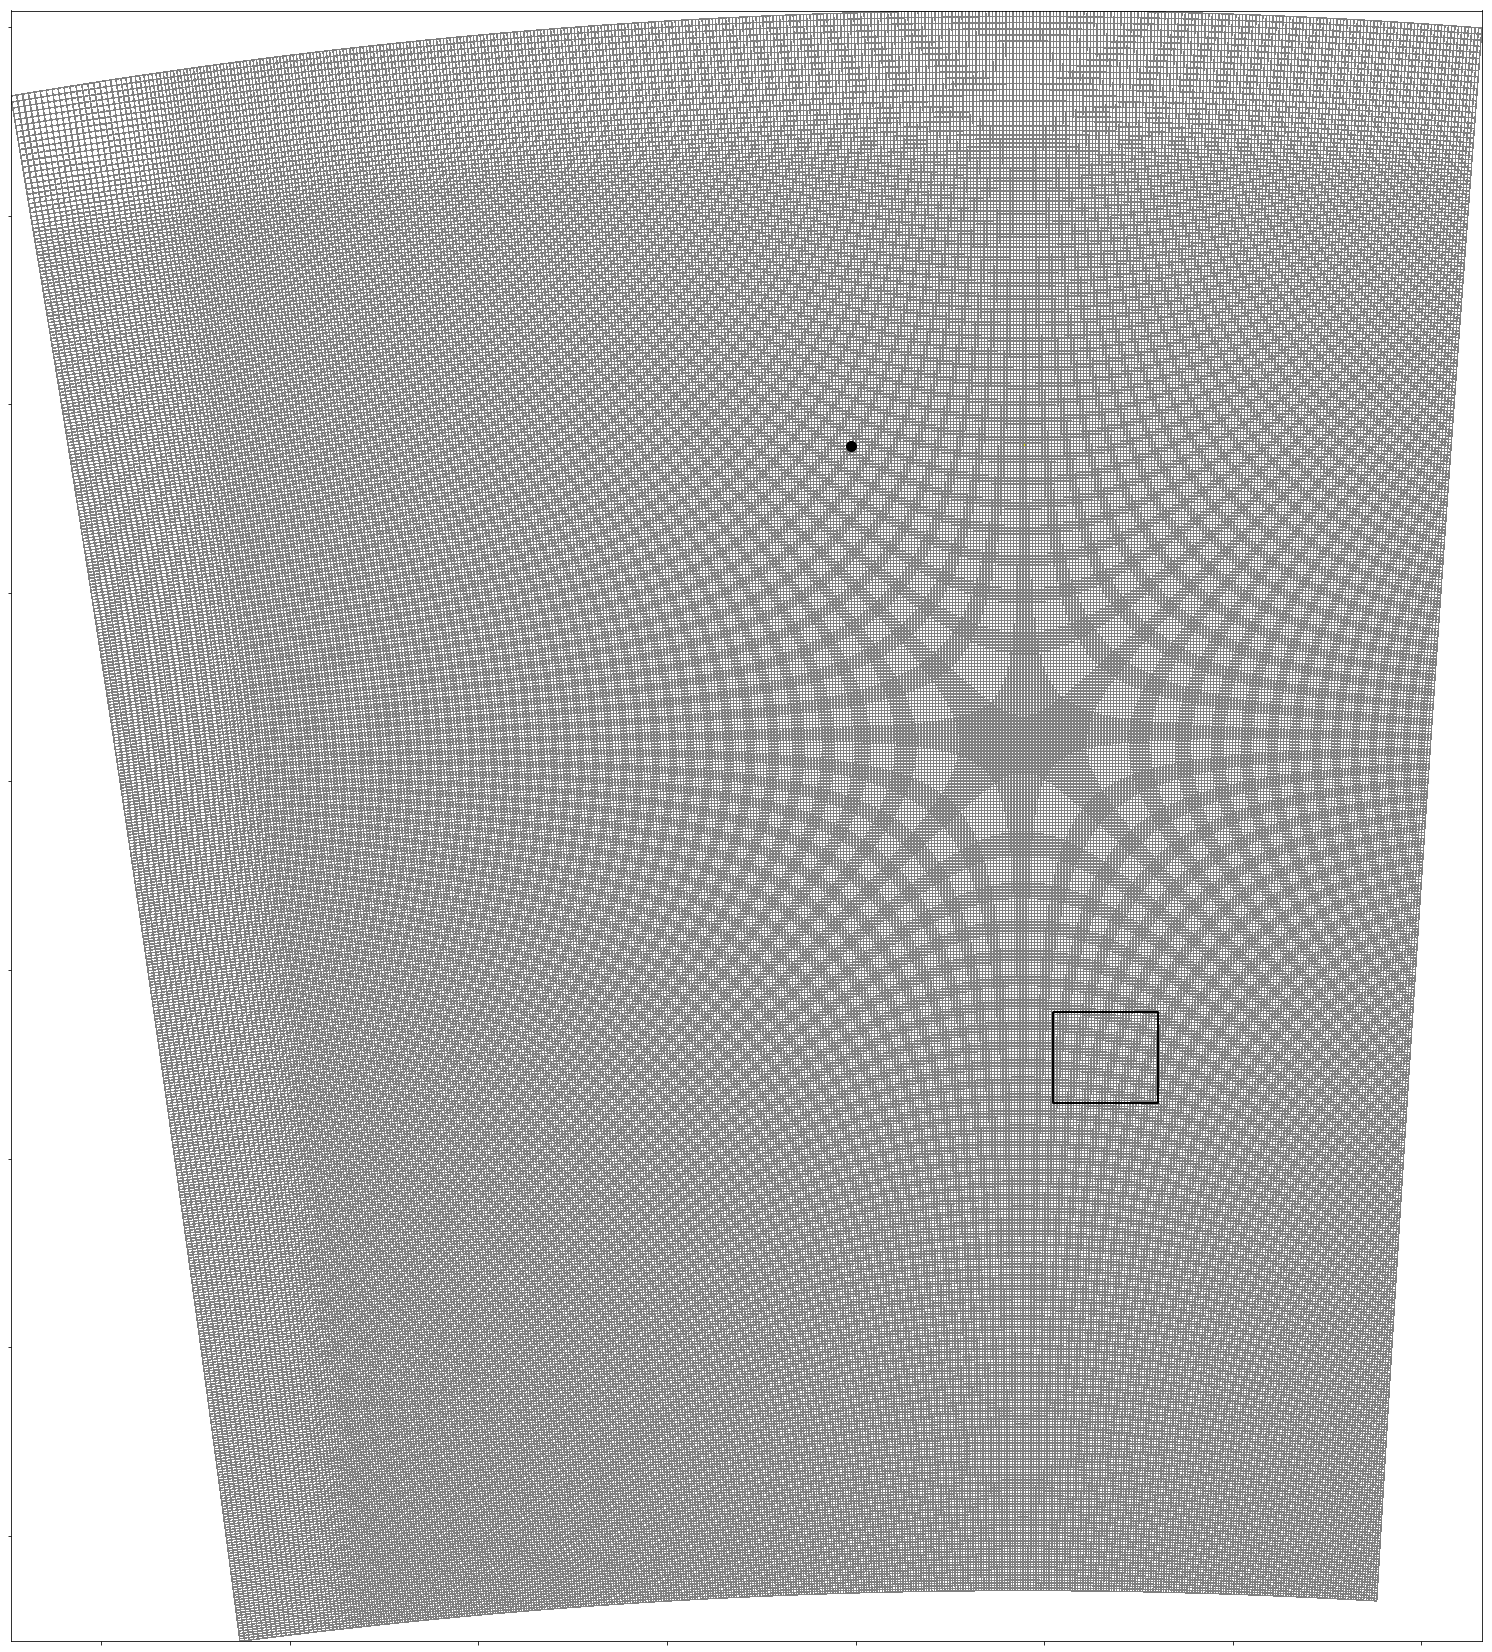

In [131]:
fig, ax = plt.subplots(figsize=(30,30))

# extent = tilemapbase.extent_from_frame(gb_gdf)
# plot = plotter = tilemapbase.Plotter(extent, tilemapbase.tiles.build_OSM(), width=500)
# plot =plotter.plot(ax)
# # Add edgecolor = 'grey' for lines
plot =ax.pcolormesh(lons_cornerpoints, lats_cornerpoints, test_data,
      linewidths=0.4, alpha = 1, cmap = cmap, edgecolors = 'grey')
plot = ax.xaxis.set_major_formatter(plt.NullFormatter())
plot = ax.yaxis.set_major_formatter(plt.NullFormatter())
# plot =leeds_gdf.plot(ax=ax, categorical=True, alpha=1, edgecolor='black', color='none', linewidth=2)
plot =leeds_at_centre_gdf.plot(ax=ax, categorical=True, alpha=1, edgecolor='black', color='none', linewidth=2)
plt.plot(lon_wm, lat_wm,  'o', color='black', markersize = 10)     
#plt.savefig('Scripts/UKCP18/RainGaugeAnalysis/Figs/CheckingLocations/UKCP18/{}.png'.format(station_name),
#           bbox_inches = 'tight')
plt.show()

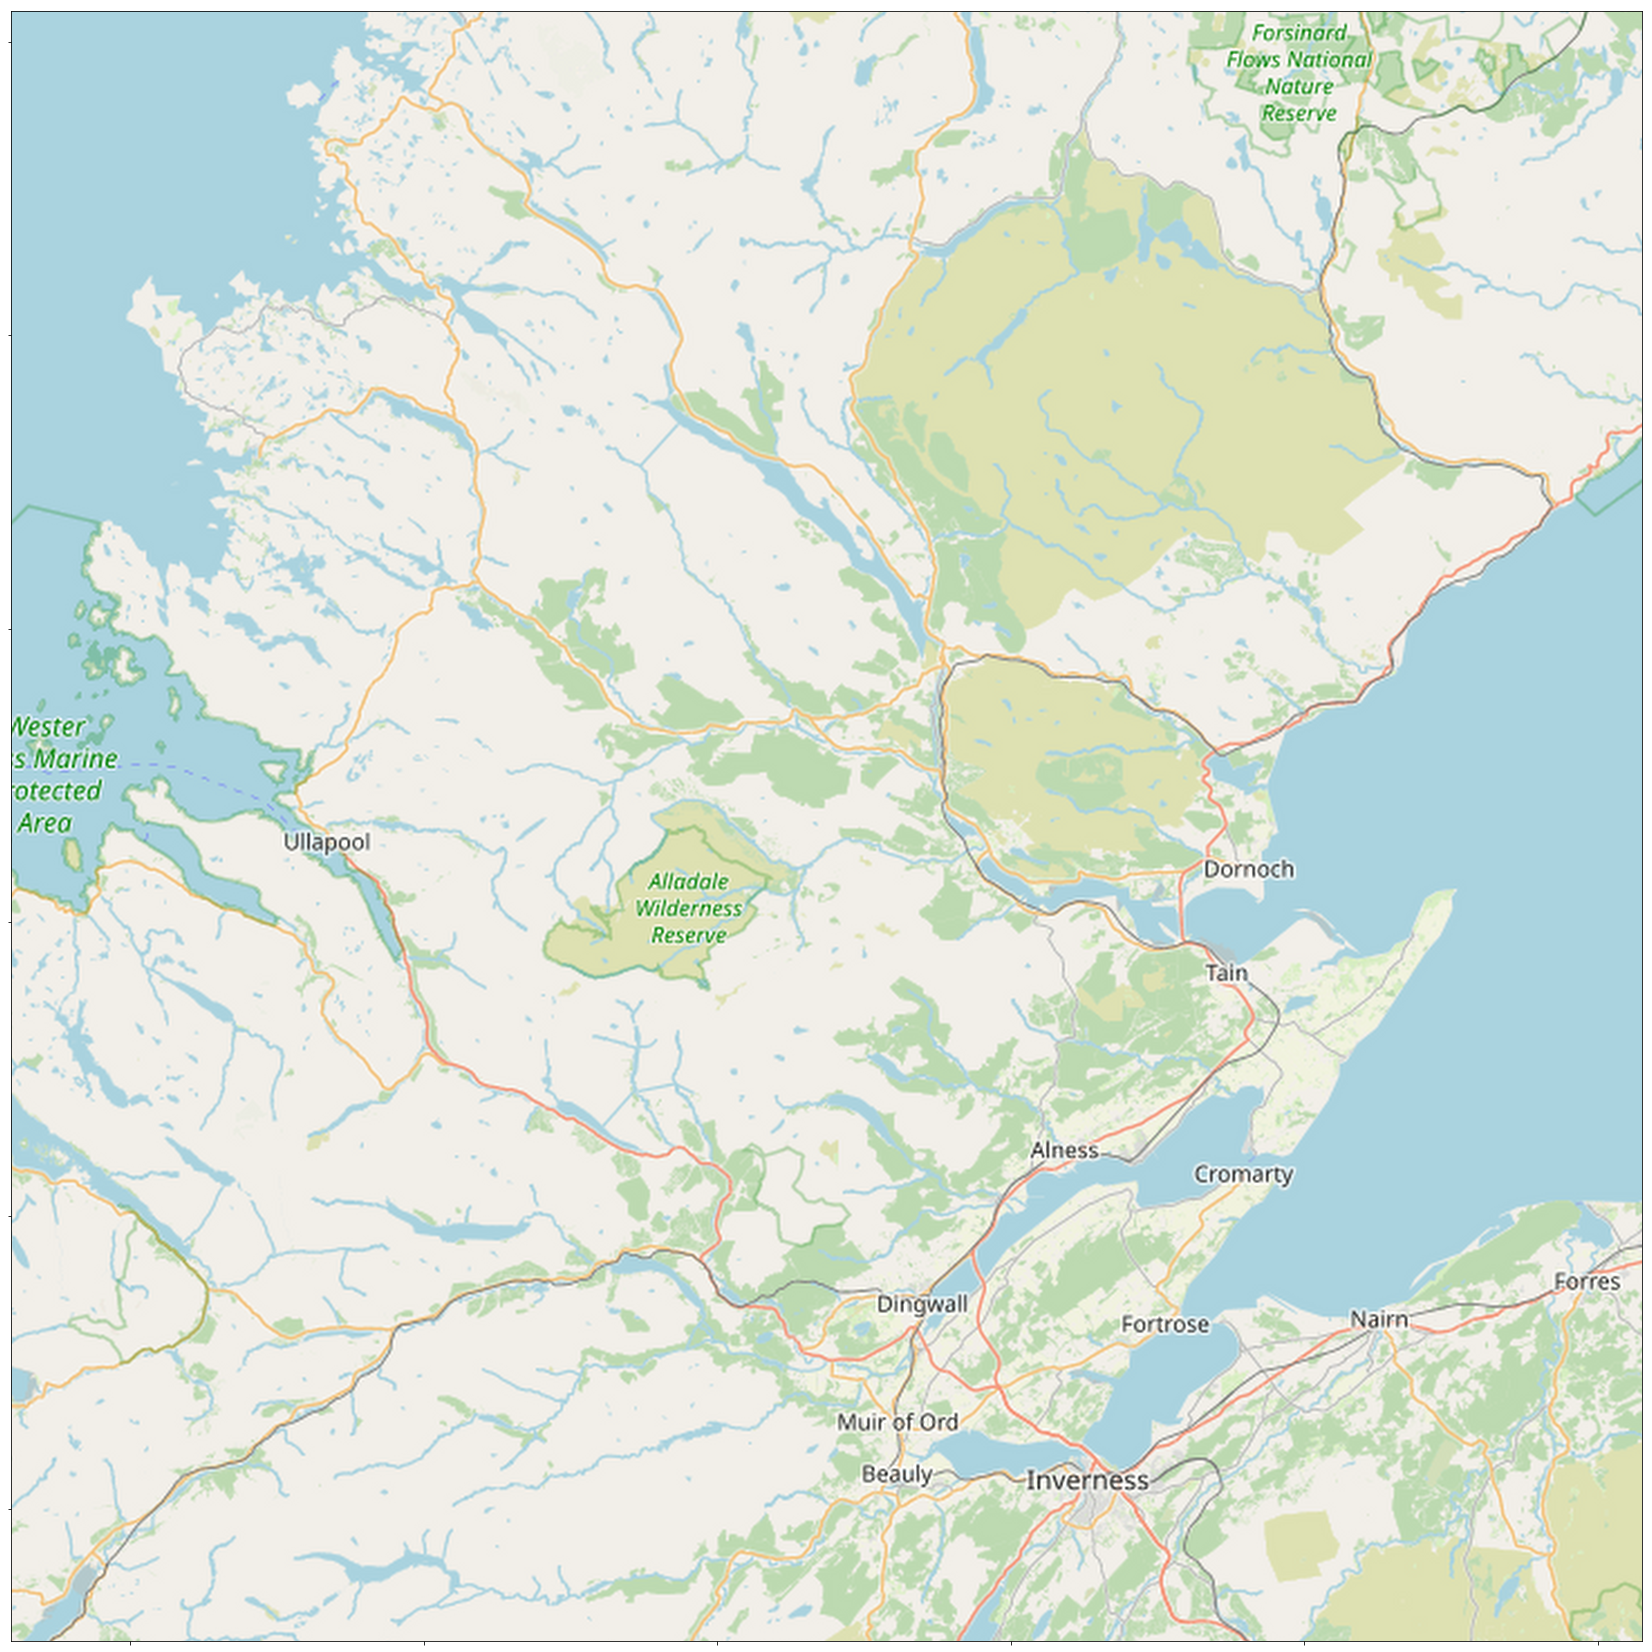

In [130]:
fig, ax = plt.subplots(figsize=(30,30))

plot = plotter = tilemapbase.Plotter(extent, t, width=600)
plot = plotter.plot(ax, t)

# extent = tilemapbase.extent_from_frame(gb_gdf)
# plot = plotter = tilemapbase.Plotter(extent, tilemapbase.tiles.build_OSM(), width=500)
# plot =plotter.plot(ax)
# # Add edgecolor = 'grey' for lines
plot =ax.pcolormesh(lons_cornerpoints, lats_cornerpoints, test_data,
      linewidths=0.4, alpha = 1, cmap = cmap, edgecolors = 'grey')
plot = ax.xaxis.set_major_formatter(plt.NullFormatter())
plot = ax.yaxis.set_major_formatter(plt.NullFormatter())
# plot =leeds_gdf.plot(ax=ax, categorical=True, alpha=1, edgecolor='black', color='none', linewidth=2)
plot =leeds_at_centre_gdf.plot(ax=ax, categorical=True, alpha=1, edgecolor='black', color='none', linewidth=2)
plt.plot(lon_wm, lat_wm,  'o', color='black', markersize = 10)     
#plt.savefig('Scripts/UKCP18/RainGaugeAnalysis/Figs/CheckingLocations/UKCP18/{}.png'.format(station_name),
#           bbox_inches = 'tight')
plt.show()